In [4]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm,wandb

import IPython.display as disp
from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d

In [5]:
%env WANDB_SILENT=true
warnings.filterwarnings('ignore')

env: WANDB_SILENT=true


In [6]:
VERSION  = "NB_EXP_006"
EXP_NAME = f"{VERSION}_convnext_tiny"

CSV_PATH     = Path('/data/train.csv')
DATA_PATH    = Path('/data/')
IMAGE_FOLDER = Path('/data/train/')
MODEL_FOLDER = Path(f'/runs/{VERSION}')

os.makedirs(MODEL_FOLDER, exist_ok=True)

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}


TIMM_MODEL  = "convnext_tiny_in22ft1k"

NFOLDS = 5
BS = 32
SZ = 256
RE = True

In [7]:
all_df = pd.read_csv(CSV_PATH)
all_df.head()

,seed_id,view,image,label
0,0,top,train/00000.png,broken
1,1,bottom,train/00001.png,pure
2,3,top,train/00003.png,broken
3,4,top,train/00004.png,pure
4,5,top,train/00005.png,discolored


In [8]:
folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

In [9]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)

In [10]:
def get_dls(fold:int, size:int, bs:int, re:bool = False):
    
    item_tfms = [ToTensor, Resize(448, method=ResizeMethod.Squish)]
    aug_tfm = aug_transforms(flip_vert=True, 
                             size=size, 
                             max_rotate=360, 
                             max_zoom=1.3, 
                             max_lighting=0.1, 
                             p_lighting=0.25, 
                             pad_mode=PadMode.Zeros,
                             min_scale=0.75)
    batch_tfms = [IntToFloatTensor, *aug_tfm, Normalize.from_stats(*imagenet_stats)]
    if re: batch_tfms.append(RandomErasing())
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter   = IndexSplitter(fold_splits[fold]),
        get_x      = ColReader('image', pref=DATA_PATH),
        get_y      = [ColReader('label')],
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms )
    
    dls = dblock.dataloaders(folds, bs=bs)
    return dls

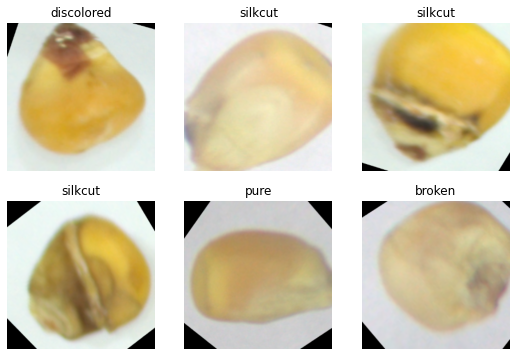

In [11]:
dls = get_dls(0, size=SZ, bs=BS, re=RE)
dls.show_batch(max_n=6)

In [12]:
from timm.models.helpers import group_modules, group_parameters

def timm_get_module_names(m):
    modules_names = group_modules(m, m.group_matcher(coarse=True))
    return L(modules_names.values())[:-1] #cut timm head

def timm_get_param_names(m):
    param_names = group_parameters(m, m.group_matcher(coarse=True))
    return L(param_names.values())[:-1] #cut timm head

def timm_body_params(timm_model, cut=-1):
    param_names = timm_get_param_names(timm_model)
    return L(param_names[:cut].concat(), param_names[cut:].concat())

def timm_split(m, cut=-1):
    "Splitter function for timm models"
    timm_model, head = m[0].model, m[1]
    body_groups = [g.map(timm_model.get_parameter) for g in timm_body_params(timm_model, cut)]
    return body_groups + [params(head)]


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



SuggestedLRs(valley=0.0003981071640737355, slide=0.0003311311302240938)
CPU: 617/55/3529 MB | GPU: 360/1368/6499 MB | Time 0:00:10.425 | (Consumed/Peaked/Used Total)


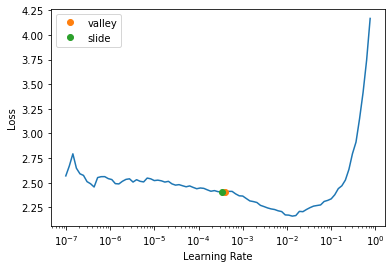

In [13]:
set_seed(42);set_fast_norm()

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    dls = get_dls(0, size=SZ, bs=BS, re=RE)
    
    learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                loss_func=CrossEntropyLossFlat(), metrics=[accuracy], splitter=timm_split).to_fp16()
    
    print(learn.lr_find(suggest_funcs=(valley, slide)))

In [17]:
n_epo = 15; base_lr = 5e-03; 
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_ft"
print(EXP_NAME+'_'+SUFFIX)
set_seed(42); set_fast_norm()

NB_EXP_006_convnext_tiny_256_bs32_epo15_ft


In [18]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
            
            wandb.define_metric('accuracy', hidden=False, summary="max")
        
            dls = get_dls(fold_idx, size=SZ, bs=BS, re=RE)

            learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                                   loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                                   splitter=default_split).to_fp16()

            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),WandbCallback(log_preds=None)]
            learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.037150,0.827224,0.684119,00:37


Better model found at epoch 0 with accuracy value: 0.6841186881065369.


epoch,train_loss,valid_loss,accuracy,time
0,0.784237,0.667089,0.727749,00:48
1,0.729598,0.635572,0.738220,00:48
2,0.687619,0.659223,0.732635,00:48
3,0.688085,0.597637,0.764398,00:48
4,0.653373,0.583730,0.763700,00:48
5,0.629500,0.567058,0.776963,00:48
6,0.580085,0.509041,0.792670,00:48
7,0.540092,0.525981,0.793368,00:48
8,0.526065,0.512902,0.794066,00:48
9,0.505833,0.502446,0.796510,00:48


Better model found at epoch 0 with accuracy value: 0.727748692035675.
Better model found at epoch 1 with accuracy value: 0.7382199168205261.
Better model found at epoch 3 with accuracy value: 0.764397919178009.
Better model found at epoch 5 with accuracy value: 0.7769633531570435.
Better model found at epoch 6 with accuracy value: 0.7926701307296753.
Better model found at epoch 7 with accuracy value: 0.7933682203292847.
Better model found at epoch 8 with accuracy value: 0.794066309928894.
Better model found at epoch 9 with accuracy value: 0.7965096235275269.
Better model found at epoch 11 with accuracy value: 0.7982547879219055.
Better model found at epoch 13 with accuracy value: 0.8020942211151123.
CPU: 336/89/3867 MB | GPU: 428/2482/6927 MB | Time 0:13:02.171 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.071623,0.894206,0.663874,00:37


Better model found at epoch 0 with accuracy value: 0.6638743281364441.


epoch,train_loss,valid_loss,accuracy,time
0,0.793189,0.657710,0.741361,00:48
1,0.713464,0.617684,0.754974,00:48
2,0.701585,0.623778,0.756370,00:48
3,0.662829,0.573900,0.773822,00:48
4,0.685491,0.639290,0.747295,00:48
5,0.606533,0.534850,0.785689,00:48
6,0.598931,0.526957,0.793717,00:48
7,0.552176,0.537825,0.787435,00:48
8,0.542576,0.503472,0.793019,00:48
9,0.527227,0.513222,0.798255,00:48


Better model found at epoch 0 with accuracy value: 0.7413612604141235.
Better model found at epoch 1 with accuracy value: 0.754973828792572.
Better model found at epoch 2 with accuracy value: 0.7563700079917908.
Better model found at epoch 3 with accuracy value: 0.773822009563446.
Better model found at epoch 5 with accuracy value: 0.7856893539428711.
Better model found at epoch 6 with accuracy value: 0.7937172651290894.
Better model found at epoch 9 with accuracy value: 0.7982547879219055.
Better model found at epoch 10 with accuracy value: 0.8097731471061707.
Better model found at epoch 11 with accuracy value: 0.811867356300354.
Better model found at epoch 13 with accuracy value: 0.8122164011001587.
Better model found at epoch 14 with accuracy value: 0.8125654458999634.
CPU: 2/88/3870 MB | GPU: 160/2668/7087 MB | Time 0:13:15.486 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.070260,0.860496,0.656075,00:38


Better model found at epoch 0 with accuracy value: 0.6560754179954529.


epoch,train_loss,valid_loss,accuracy,time
0,0.754474,0.648392,0.736383,00:48
1,0.737427,0.665127,0.731145,00:48
2,0.683923,0.638238,0.747556,00:48
3,0.652655,0.586385,0.764316,00:48
4,0.663129,0.568373,0.771299,00:48
5,0.629818,0.551068,0.778980,00:48
6,0.579455,0.602236,0.767807,00:48
7,0.562174,0.521901,0.798184,00:48
8,0.536250,0.505411,0.796089,00:48
9,0.508950,0.502753,0.793296,00:48


Better model found at epoch 0 with accuracy value: 0.7363826632499695.
Better model found at epoch 2 with accuracy value: 0.7475558519363403.
Better model found at epoch 3 with accuracy value: 0.764315664768219.
Better model found at epoch 4 with accuracy value: 0.771298885345459.
Better model found at epoch 5 with accuracy value: 0.7789804339408875.
Better model found at epoch 7 with accuracy value: 0.798184335231781.
Better model found at epoch 13 with accuracy value: 0.8009776473045349.
CPU: 1/87/3871 MB | GPU: 74/2596/7161 MB | Time 0:13:07.221 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.027660,0.833096,0.680168,00:37


Better model found at epoch 0 with accuracy value: 0.6801676154136658.


epoch,train_loss,valid_loss,accuracy,time
0,0.753318,0.646172,0.738827,00:48
1,0.741074,0.628768,0.750698,00:48
2,0.706571,0.584433,0.765014,00:48
3,0.683139,0.571400,0.771299,00:48
4,0.660140,0.561129,0.772346,00:48
5,0.667406,0.529927,0.776536,00:48
6,0.582758,0.504460,0.797486,00:48
7,0.581298,0.496979,0.791201,00:48
8,0.520606,0.489008,0.798184,00:48
9,0.537274,0.481053,0.804818,00:48


Better model found at epoch 0 with accuracy value: 0.7388268113136292.
Better model found at epoch 1 with accuracy value: 0.7506983280181885.
Better model found at epoch 2 with accuracy value: 0.7650139927864075.
Better model found at epoch 3 with accuracy value: 0.771298885345459.
Better model found at epoch 4 with accuracy value: 0.7723463773727417.
Better model found at epoch 5 with accuracy value: 0.7765362858772278.
Better model found at epoch 6 with accuracy value: 0.7974860072135925.
Better model found at epoch 8 with accuracy value: 0.798184335231781.
Better model found at epoch 9 with accuracy value: 0.8048184514045715.
Better model found at epoch 10 with accuracy value: 0.8131983280181885.
Better model found at epoch 11 with accuracy value: 0.8177374005317688.
Better model found at epoch 12 with accuracy value: 0.8233240246772766.
CPU: 0/86/3871 MB | GPU: 72/2532/7233 MB | Time 0:13:05.052 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device:

epoch,train_loss,valid_loss,accuracy,time
0,1.019768,0.932596,0.660265,00:37


Better model found at epoch 0 with accuracy value: 0.6602653861045837.


epoch,train_loss,valid_loss,accuracy,time
0,0.787769,0.653457,0.736033,00:48
1,0.717911,0.607254,0.752793,00:48
2,0.720764,0.630605,0.752444,00:48
3,0.675782,0.569652,0.767458,00:48
4,0.673287,0.582920,0.771997,00:48
5,0.647683,0.550074,0.785615,00:48
6,0.580855,0.564035,0.780377,00:48
7,0.568678,0.519726,0.797137,00:48
8,0.546335,0.486661,0.798883,00:48
9,0.528955,0.498886,0.796089,00:48


Better model found at epoch 0 with accuracy value: 0.7360334992408752.
Better model found at epoch 1 with accuracy value: 0.7527933120727539.
Better model found at epoch 3 with accuracy value: 0.7674580812454224.
Better model found at epoch 4 with accuracy value: 0.7719972133636475.
Better model found at epoch 5 with accuracy value: 0.785614550113678.
Better model found at epoch 7 with accuracy value: 0.7971368432044983.
Better model found at epoch 8 with accuracy value: 0.7988826632499695.
Better model found at epoch 10 with accuracy value: 0.8013268113136292.
Better model found at epoch 11 with accuracy value: 0.8041201233863831.
Better model found at epoch 12 with accuracy value: 0.8051676154136658.
Better model found at epoch 13 with accuracy value: 0.8065642714500427.
Better model found at epoch 14 with accuracy value: 0.8093575239181519.
CPU: 30/83/3901 MB | GPU: 60/2498/7293 MB | Time 0:13:07.100 | (Consumed/Peaked/Used Total)


In [19]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        dls = get_dls(fold_index, size=SZ, bs=BS, re=RE)

        learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                               loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                               splitter=timm_split, model_dir=MODEL_FOLDER).to_fp16()
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"Load from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # original dl with validation tfms
        tst_dl = dls.valid.new()
        with tst_dl.dataset.set_split_idx(1), learn.no_mbar():
            preds0, targs = learn.get_preds(dl=tst_dl)
        
        # dl with hflip
        tst_dl_1 = dls.valid.new()
        tst_dl_1.after_batch.add(hflip)
        with tst_dl_1.dataset.set_split_idx(1), learn.no_mbar():
            preds1, _ = learn.get_preds(dl=tst_dl_1)
        
        # dl with vflip tfms
        tst_dl_2 = dls.valid.new()
        tst_dl_2.after_batch.add(vflip)
        with tst_dl_2.dataset.set_split_idx(1), learn.no_mbar():
            preds2, _ = learn.get_preds(dl=tst_dl_2)
        
        preds = (preds0+preds1+preds2)/3
        acc = accuracy(preds, targs).item()
        
        folds_val_score.append(acc)

disp.clear_output()    
print("============ Run summary (hflip+vflip TTA) ============")
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

============ Run summary (hflip+vflip TTA) ============
folds score:  [0.80349, 0.81117, 0.80517, 0.82821, 0.81145]
Avg: 0.81190
Std: 0.00875
